Trailed source model from Vereš et al. 2012 method

In [123]:
import numpy as np
from scipy.special import erf

from scipy.optimize import minimize
from scipy.stats import norm, poisson

import matplotlib.pyplot as plt
%matplotlib inline

In [124]:
def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [125]:
def trailedModel(x,y,b,F,sigma,L,theta,x0,y0):
    A = F/(L*2*sigma*np.sqrt(2.0*np.pi))
    B = np.exp(-((x-x0)*np.sin(theta) + (y-y0)*np.cos(theta))**2.0 / (2.0 * sigma**2))
    C = erf(((x-x0)*np.cos(theta) + (y-y0)*np.sin(theta) + L/2) / (sigma * np.sqrt(2)))
    D = erf(((x-x0)*np.cos(theta) + (y-y0)*np.sin(theta) - L/2) / (sigma * np.sqrt(2)))
    return b + A * B * (C - D)

def makeModelImage(params, xdim, ydim, args, noise=False):
    F, L, theta, x0, y0 = params
    b, sigma = args
    
    x = np.arange(-dims//2 + 1, dims//2 + 1)
    y = np.arange(-dims//2 + 1, dims//2 + 1)
    im = trailedModel(x[None,:],y[:,None],b,F,sigma,L,theta,x0,y0)
    
    if noise: im = np.random.poisson(im)
    
    return im

In [126]:
trailedModel(0,0,0,1200,1.5,1,0,0,0)

83.33659115846736

SNR:  9.796020669168653
Noise:  30.558736311965287


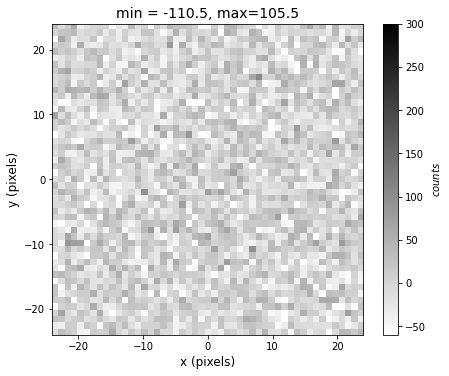

In [127]:
dims = 49
x0 = 0.0
y0 = 0.0
F = 5500.2
sigma = 1.5
L = 5
b = 912.5
theta = np.pi/3
params = np.array([F,L,theta,x0,y0])
args = np.array([b, sigma])
print("SNR: ", F * 0.66 / np.sqrt(b) / (2.335 * sigma)**2)

# Estimate noise sigma from diff images
data = makeModelImage(params, dims, dims, args, noise=True)
diff_im = data - makeModelImage(params, dims, dims, args, noise=False)
noise = np.std(diff_im)
print("Noise: ", noise)
plotCutout(diff_im)

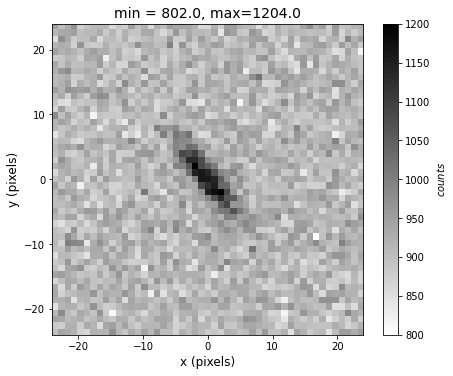

In [128]:
plotCutout(data,clim=(800,1200))

In [129]:
def chi_squared(params, data, error, args):
    dims = data.shape
    model = makeModelImage(params, *dims, args)
    return np.sum(((data - model) / error)**2)

In [130]:
dims = 25
x0 = 0.0
y0 = 0.0
F = 5500.2
sigma = 1.5
L = 5
b = 912.5
theta = np.pi/3

params = np.array([F,L,theta,x0,y0])
args = np.array([b, sigma])

data = makeModelImage(params, dims, dims, args, noise=True)
error = np.ones(data.shape) * np.std(diff_im)
chi_squared(params, data, error, args) / (data.size - 5 - 1)

1.1359763528055764

In [131]:
dims = 25
x0 = 0.4
y0 = -0.2
F = 5503.2
sigma = 1.5
L = 5
b = 912.5
theta = np.pi/3

params = np.array([F, L, theta, x0, y0])
args = np.array([b, sigma])

In [132]:
%%time
res = minimize(chi_squared, params, args=(data, error, args), method='Nelder-Mead', options={'maxiter':5000})

CPU times: user 128 ms, sys: 1.63 ms, total: 130 ms
Wall time: 128 ms


1.1257465737029309


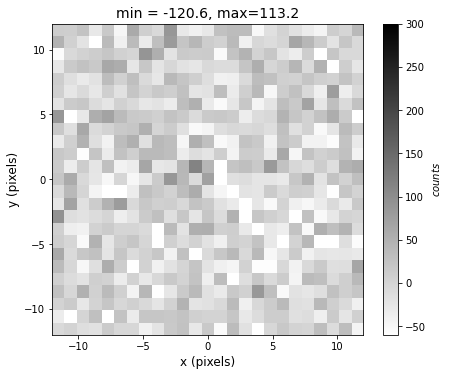

In [133]:
fit_image = makeModelImage(params, dims, dims, args, noise=False)
print(res.fun / (fit_image.size - 5 - 1))
plotCutout(data - fit_image)

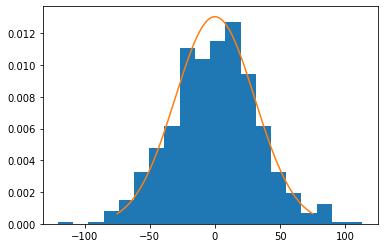

In [134]:
plt.hist((data-fit_image).flatten(), bins = 20, density=True)
x = np.arange(-75,75,0.01)
y = norm.pdf(x,0,noise)
plt.plot(x,y)